### Definition of audio terms.
1. Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

2. Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

3. Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

4. Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.

5. Loudness: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude).

6. Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

7. Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

### Importing the modules required

In [237]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, boxcox, norm
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
sns.set(rc = {'figure.figsize':(21, 10)})

In [238]:
data = pd.read_csv("top10s.csv", encoding="latin-1", parse_dates=True, index_col="year")

#### Well the data columns are a bit hard to interpret lets rename them.

In [239]:
data.rename(columns= {"Unnamed: 0":"Serial_No.", 
                      "title":"Title", "artist":"Artist", 
                      "top genre":"Genre", 
                      "year":"Year", 
                      "bpm":"Beats_Per_Minute", 
                      "nrgy":"Energy",
                      "dnce":"Danceability", 
                      "dB":"Loudness_dB", 
                      "live":"Liveness", 
                      "val":"Valence", 
                      "dur":"Duration", 
                      "acous":"Acousticness", 
                      "spch":"Speechiness", 
                      "pop":"Popularity"}, inplace=True)

#### Lets see if we have any missing values or not and the datatypes of our columns.

In [240]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 603 entries, 2010-01-01 to 2019-01-01
Data columns (total 14 columns):
Serial_No.          603 non-null int64
Title               603 non-null object
Artist              603 non-null object
Genre               603 non-null object
Beats_Per_Minute    603 non-null int64
Energy              603 non-null int64
Danceability        603 non-null int64
Loudness_dB         603 non-null int64
Liveness            603 non-null int64
Valence             603 non-null int64
Duration            603 non-null int64
Acousticness        603 non-null int64
Speechiness         603 non-null int64
Popularity          603 non-null int64
dtypes: int64(11), object(3)
memory usage: 70.7+ KB


#### Woah! No missing values, we are safe to proceed :)

#### Lets drop the unwanted columns such as Serial_No. its of no use in our analysis.

In [241]:
data.drop(columns="Serial_No.", inplace = True)

#### Lets see the most popular songs, popularity score ranges from 0-100. Lets plot it!

In [242]:
top5_popular = data.sort_values(by = "Popularity", ascending=False).head(5)

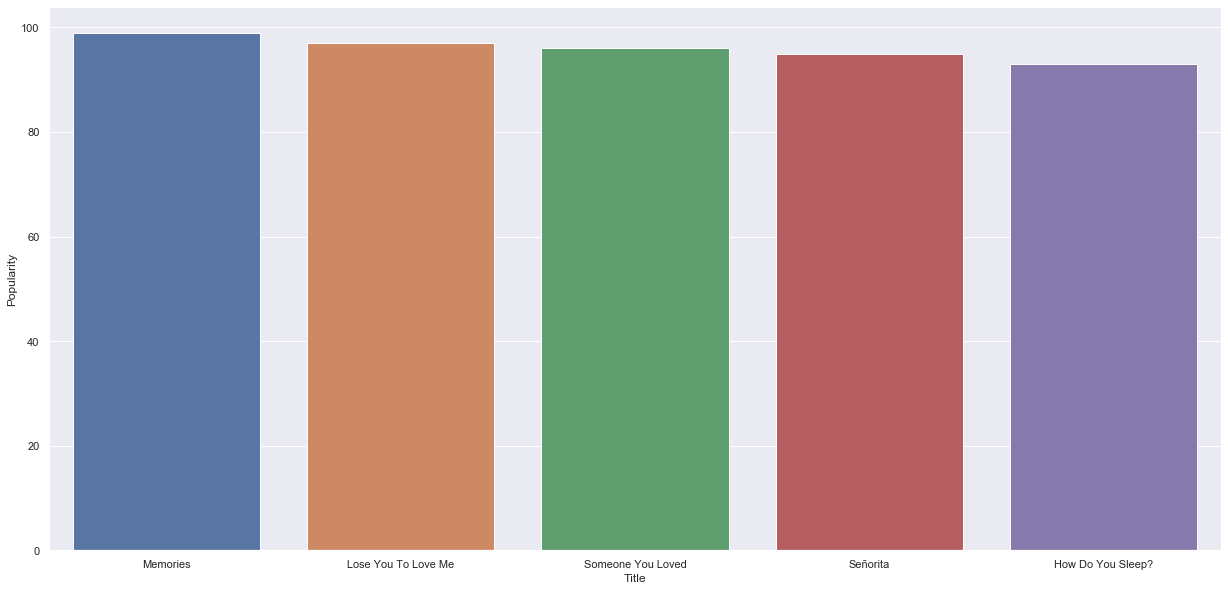

In [243]:
sns.barplot(x = "Title", y = "Popularity", data = top5_popular)

#### Lets see who are the artist's who have sang most songs from 2010 - 2019.

In [244]:
data["Artist"].value_counts().head(5) 

Katy Perry       17
Justin Bieber    16
Maroon 5         15
Rihanna          15
Lady Gaga        14
Name: Artist, dtype: int64

#### Since some of our audio features ranges  from 0 - 1, lets bring them in the range.

In [245]:
#These are some of the values which range from 0 - 1
data[["Acousticness", "Liveness", "Speechiness", "Energy", "Danceability", "Valence", "Popularity"]] = data[["Acousticness", "Liveness", "Speechiness", "Energy", "Danceability", "Valence", "Popularity"]].apply(lambda x: x/100)

In [246]:
#data.head(2)

#### Lets convert tbe duration of songs in minutes for easy interpretation.

In [247]:
data["Duration"] = data["Duration"]/60 #Now, in minutes

In [248]:
#data.head(2)

#### Lets see which Genre has ruled all this time in Spotify's top list.

In [249]:
data["Genre"].value_counts().head(5) #Dance Pop hails!

dance pop        327
pop               60
canadian pop      34
barbadian pop     15
boy band          15
Name: Genre, dtype: int64

In [250]:
data.apply(np.max) #Maximum Popularity went to 99!!!

Title               no tears left to cry
Artist                         will.i.am
Genre                     tropical house
Beats_Per_Minute                     206
Energy                              0.98
Danceability                        0.97
Loudness_dB                           -2
Liveness                            0.74
Valence                             0.98
Duration                         7.06667
Acousticness                        0.99
Speechiness                         0.48
Popularity                          0.99
dtype: object

#### There is a song with duration of 7 minutes, lets find out which one it is.

In [251]:

data[data["Duration"] > 7]

,Title,Artist,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity
year,,,,,,,,,,,,,
2013-01-01,TKO,Justin Timberlake,dance pop,138,0.68,0.61,-7,0.43,0.49,7.066667,0.01,0.24,0.58


#### Most acoustic song of all time award goes to....

In [252]:
data.sort_values(by = "Acousticness", ascending=False).head(1)

,Title,Artist,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity
year,,,,,,,,,,,,,
2016-01-01,Start,John Legend,neo mellow,110,0.04,0.52,-15,0.09,0.26,5.166667,0.99,0.04,0.47


#### Most Danceable song of all time award goes to....

In [253]:
data.sort_values(by = "Danceability", ascending=False).head(1)

,Title,Artist,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity
year,,,,,,,,,,,,,
2018-01-01,Drip (feat. Migos),Cardi B,pop,130,0.59,0.97,-8,0.08,0.27,4.4,0.05,0.26,0.45


In [254]:
data.apply(np.min)

Title                 #Beautiful
Artist                     3OH!3
Genre               acoustic pop
Beats_Per_Minute               0
Energy                         0
Danceability                   0
Loudness_dB                  -60
Liveness                       0
Valence                        0
Duration                 2.23333
Acousticness                   0
Speechiness                    0
Popularity                     0
dtype: object

#### Lets find out the song with most min duration in spotify's top list.

In [255]:
data.sort_values(by = "Duration").head(1)

,Title,Artist,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity
year,,,,,,,,,,,,,
2015-01-01,Mark My Words,Justin Bieber,canadian pop,114,0.26,0.38,-9,0.17,0.52,2.233333,0.88,0.03,0.63


#### Correlation plots will help us determine the variables which are strongly/weakly related. Lets find it out by using seaborn's library heatmap.

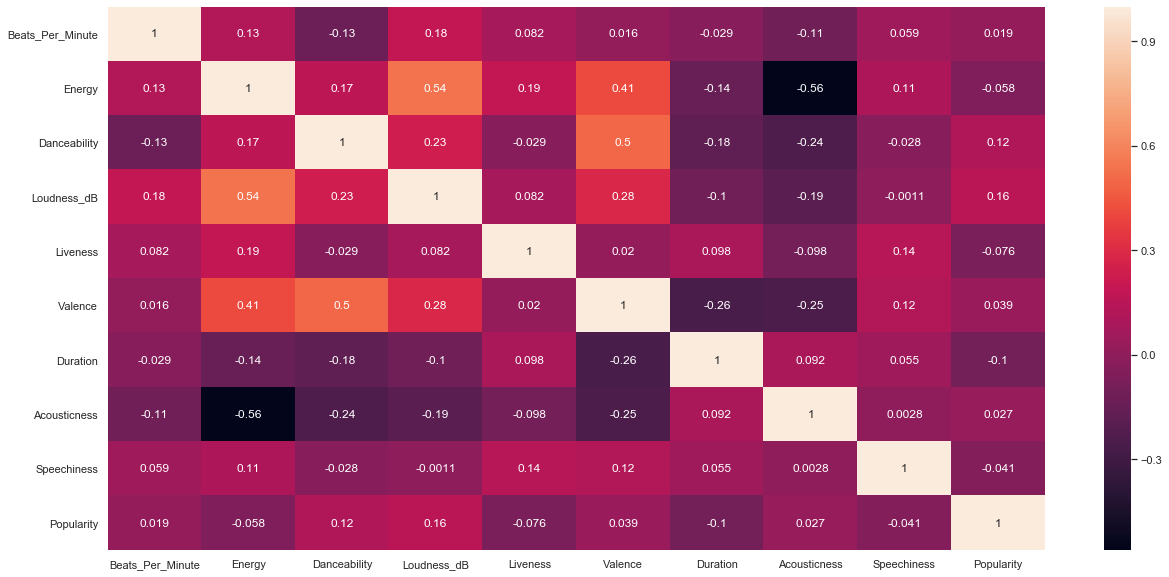

In [256]:
sns.heatmap(data = data.corr(method = "pearson"), annot=True)

#### By looking at the correlation plot, it appears that these arent much correlated except for two (Energy/Loudness and Valence/Danceability), lets plot them. We will seperate our data in two different dataframes, one with year range from 2010 to 14 and another one with 2015 to 19.

In [257]:
data_till14 = data.loc['2010':'2014']

In [258]:
data_till19 = data.loc['2015':'2019']

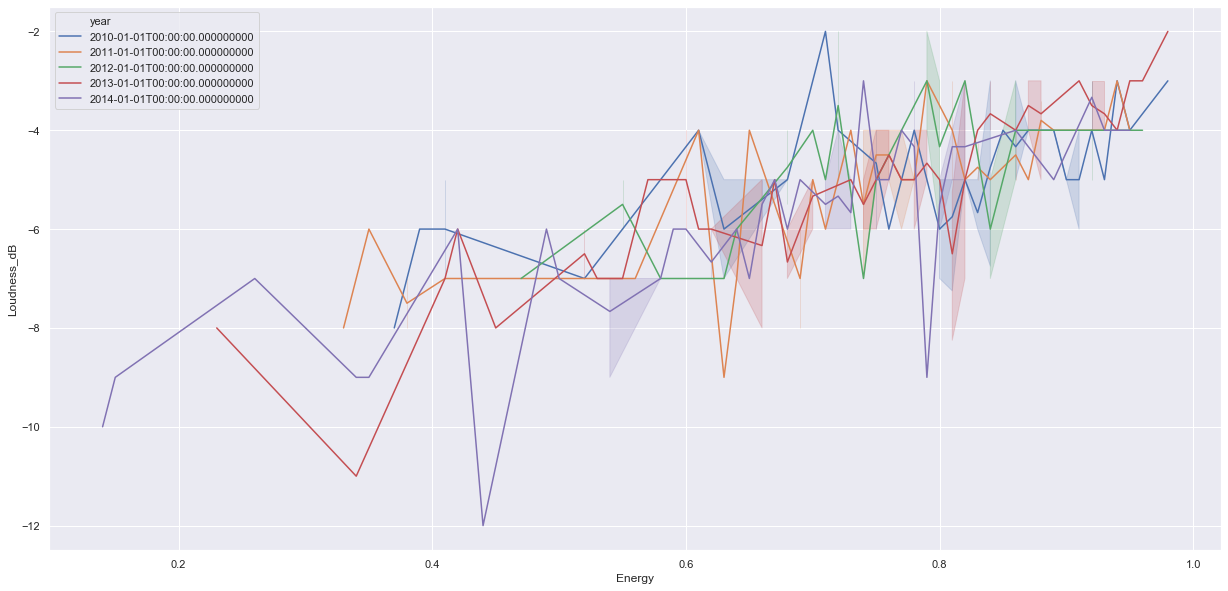

In [259]:
sns.lineplot(x = "Energy", y = "Loudness_dB", data = data_till14, hue = data_till14.index) 

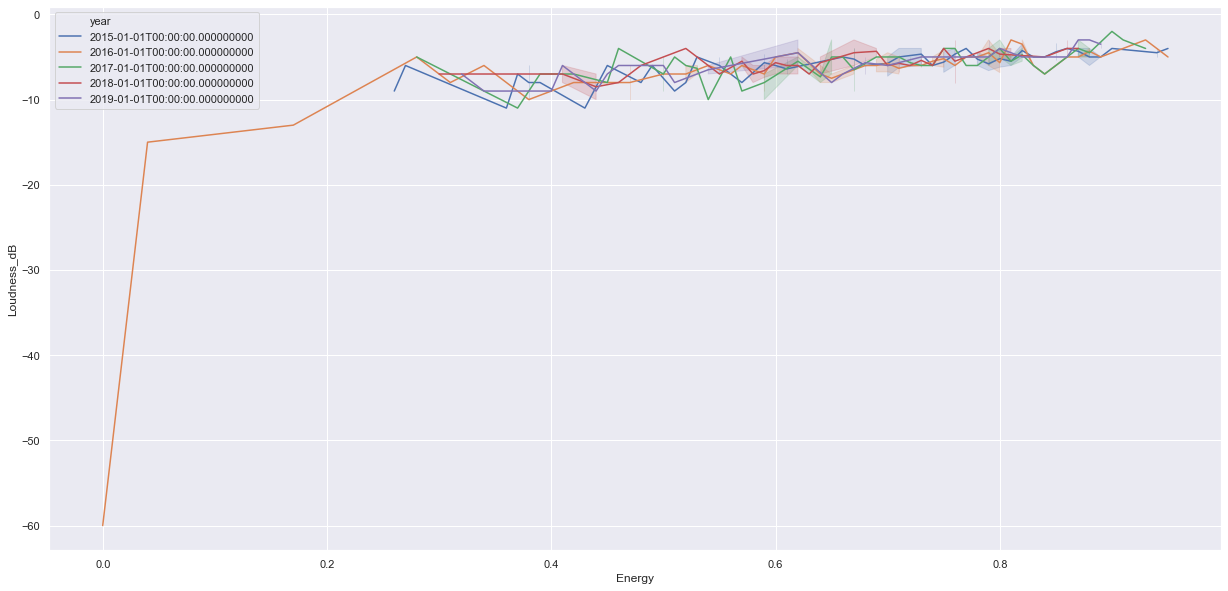

In [260]:
sns.lineplot(x = "Energy", y = "Loudness_dB", data = data_till19, hue = data_till19.index) 

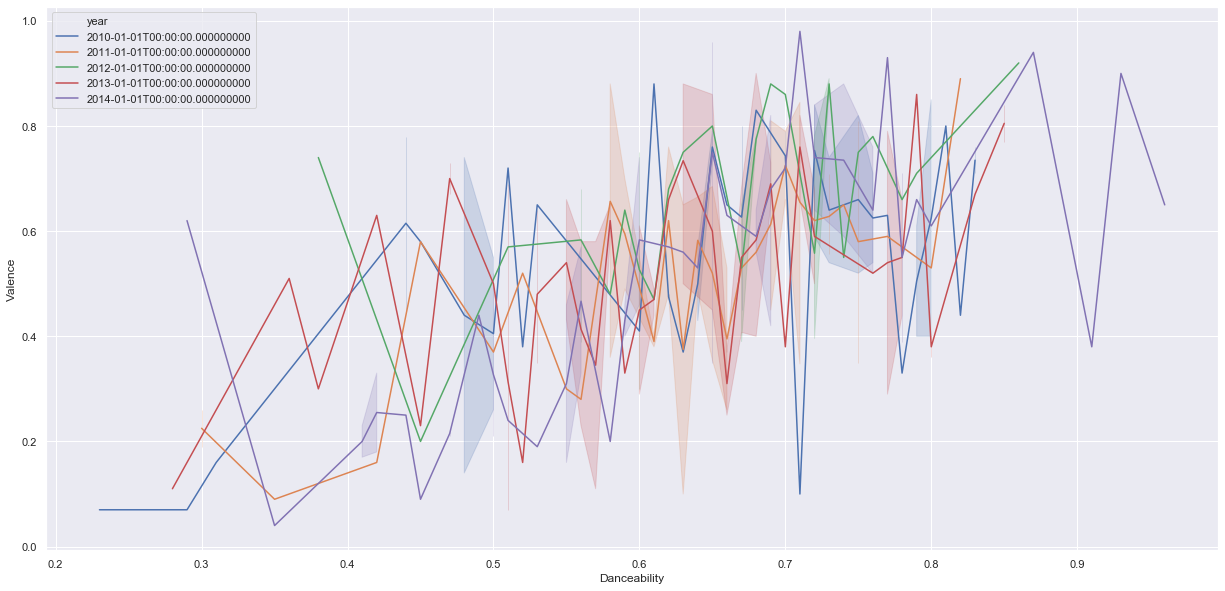

In [261]:
sns.lineplot(x = "Danceability", y = "Valence", data = data_till14, hue = data_till14.index) 

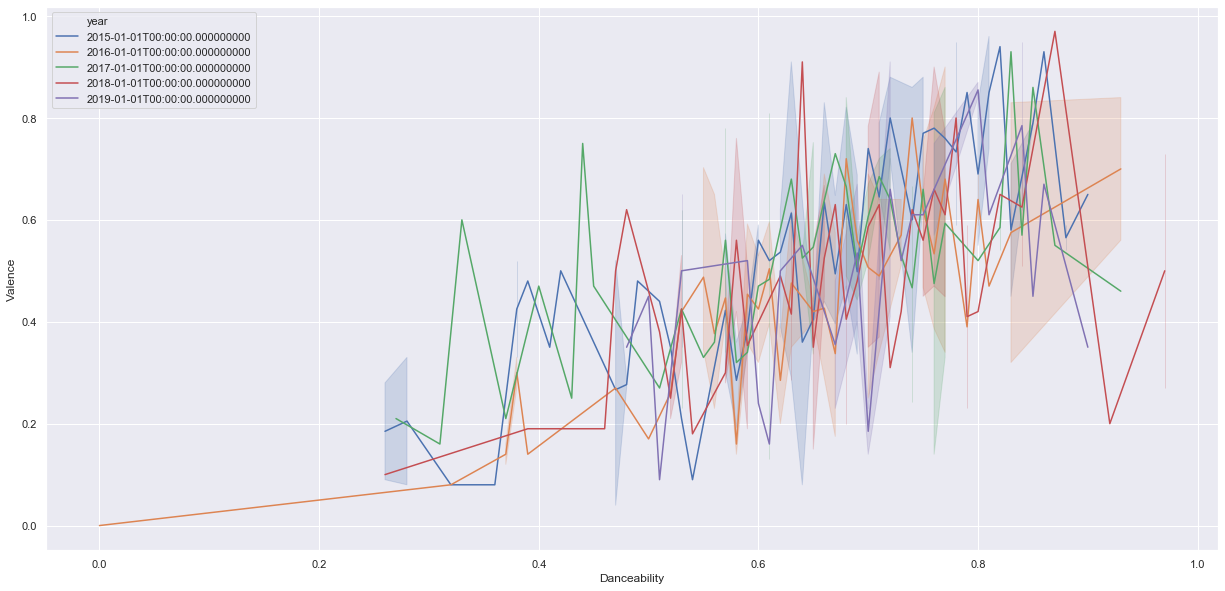

In [262]:
sns.lineplot(x = "Danceability", y = "Valence", data = data_till19, hue = data_till19.index) 

#### Lets create a new column, Pop_or_not, whether the given variables can predict if the song will be popular or not. If the popularity score is more than 0.6 it will be popular.

In [263]:
#This will be used later while applying ML models.
data["Pop_or_not"] = [1 if x >= 0.6 else 0 for x in data["Popularity"]]

In [264]:
data.head(2)

,Title,Artist,Genre,Beats_Per_Minute,Energy,Danceability,Loudness_dB,Liveness,Valence,Duration,Acousticness,Speechiness,Popularity,Pop_or_not
year,,,,,,,,,,,,,,
2010-01-01,"Hey, Soul Sister",Train,neo mellow,97,0.89,0.67,-4,0.08,0.80,3.616667,0.19,0.04,0.83,1
2010-01-01,Love The Way You Lie,Eminem,detroit hip hop,87,0.93,0.75,-5,0.52,0.64,4.383333,0.24,0.23,0.82,1


#### Lets see if our data is skewed or not.

In [265]:
for column in data[["Beats_Per_Minute", "Energy", "Danceability", "Valence",  "Liveness", "Duration", "Acousticness", "Speechiness"]]:
    print("The Skewness of {0} is: {1}".format(column, skew(data[column])))

The Skewness of Beats_Per_Minute is: 0.5357055590162509
The Skewness of Energy is: -0.9827414394516434
The Skewness of Danceability is: -0.6779035645381514
The Skewness of Valence is: -0.07372371690249721
The Skewness of Liveness is: 1.7117679410069295
The Skewness of Duration is: 1.3362114242983052
The Skewness of Acousticness is: 2.197145989320099
The Skewness of Speechiness is: 2.5343414161413684


#### Lets deal with the highly skewed data; Since the data ranges from 0 - 1 applying log transformations will result in NaN since log of 0 is undefined so we will add to our data which wont lets us run into an error.

In [266]:
for column in data[["Duration", "Liveness", "Acousticness", "Speechiness"]]:
                 data[column] += 1

#### Lets apply boxcox transformation to remove the skewness from the data.

In [267]:
for column in data[["Liveness", "Duration", "Acousticness", "Speechiness"]]:
                  data[column] = boxcox(np.asarray(data[[column]].values))[0]


In [268]:
#Lets check the skewness.
for column in data[["Liveness", "Duration", "Acousticness", "Speechiness"]]:
    print("The Skewness of {0} is: {1}".format(column, skew(data[column])))


The Skewness of Liveness is: 0.26988591026101705
The Skewness of Duration is: -0.0500245719936347
The Skewness of Acousticness is: 0.5227495044685145
The Skewness of Speechiness is: 0.4674132647124068


#### We will create a function, were we will plot our data with normal distribution.

In [269]:
def plot_dist(data):
    return sns.distplot(data, fit = norm)

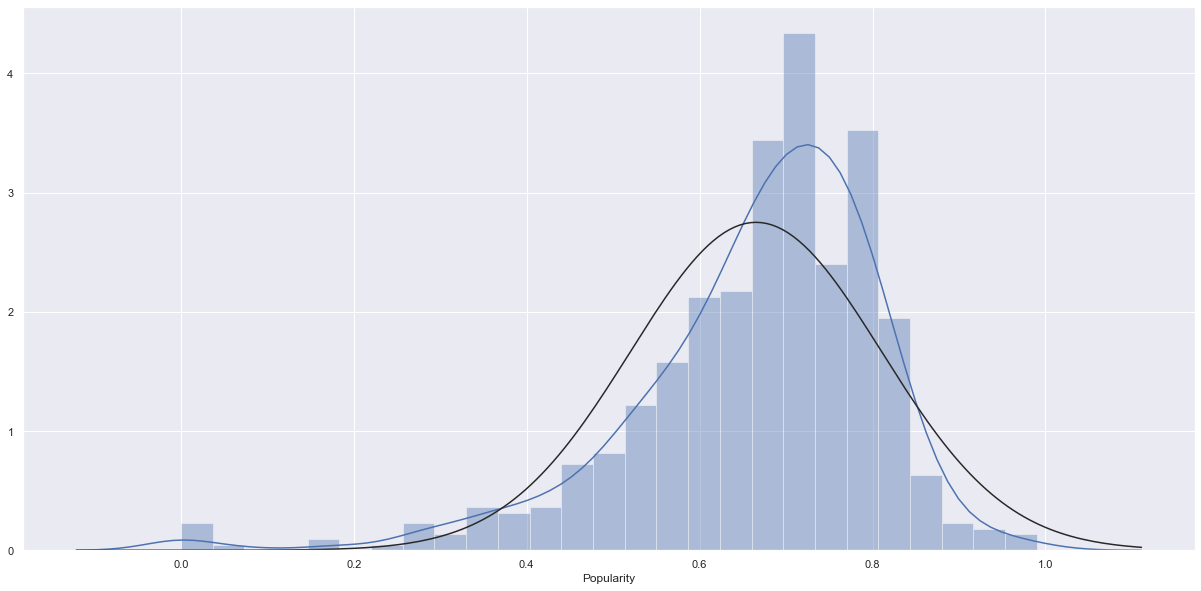

In [270]:
plot_dist(data["Popularity"])

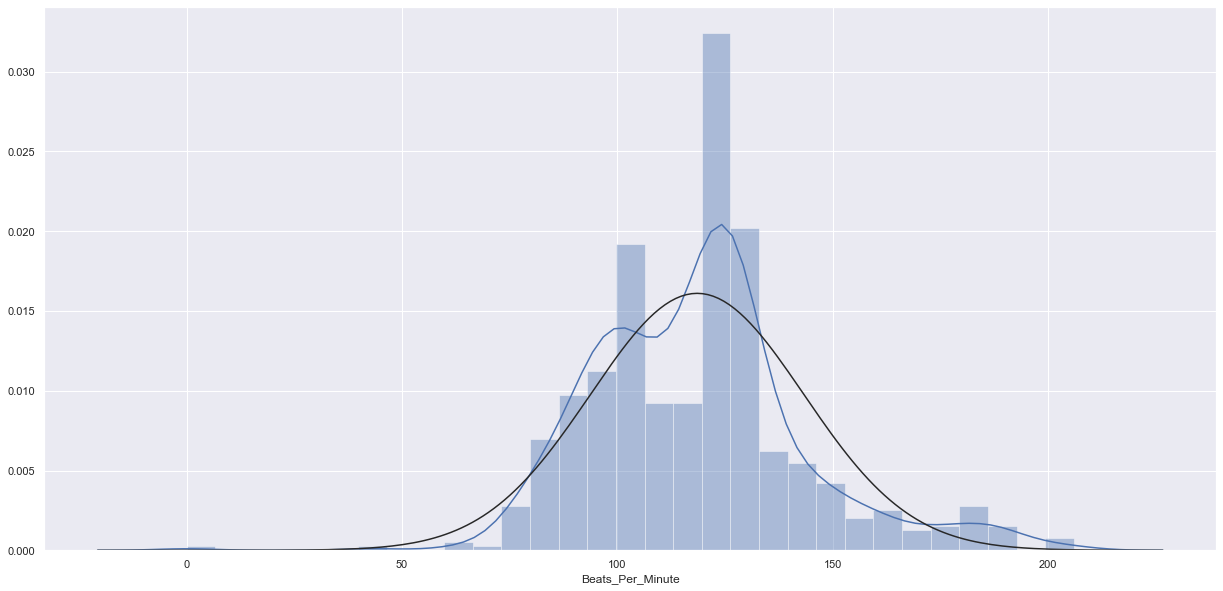

In [271]:
plot_dist(data["Beats_Per_Minute"])

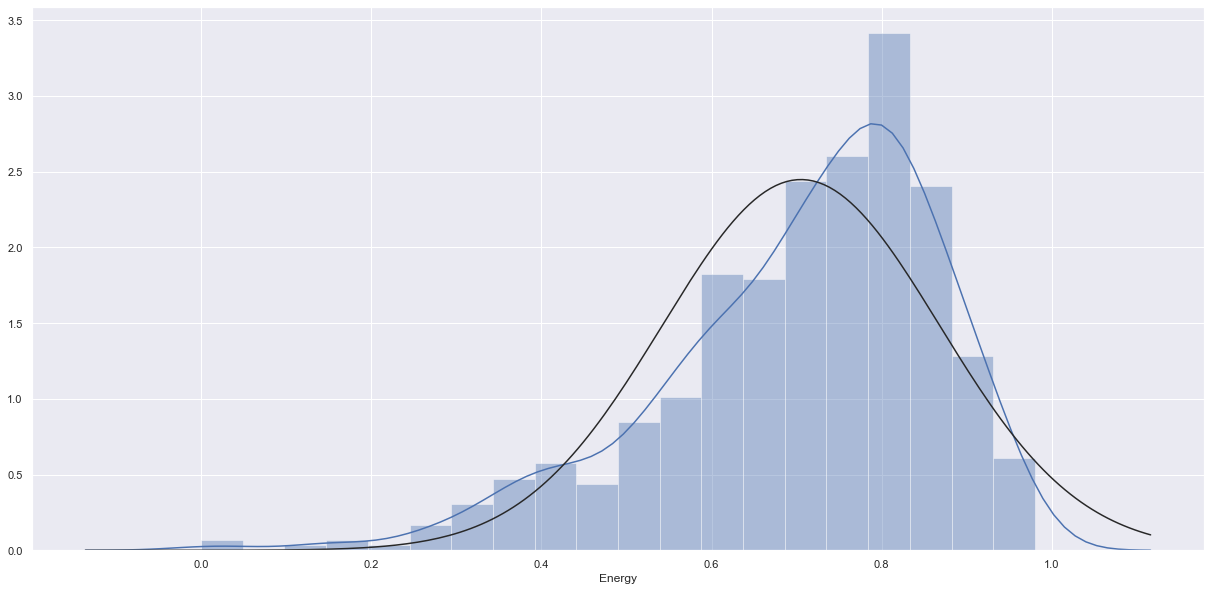

In [272]:
plot_dist(data["Energy"])

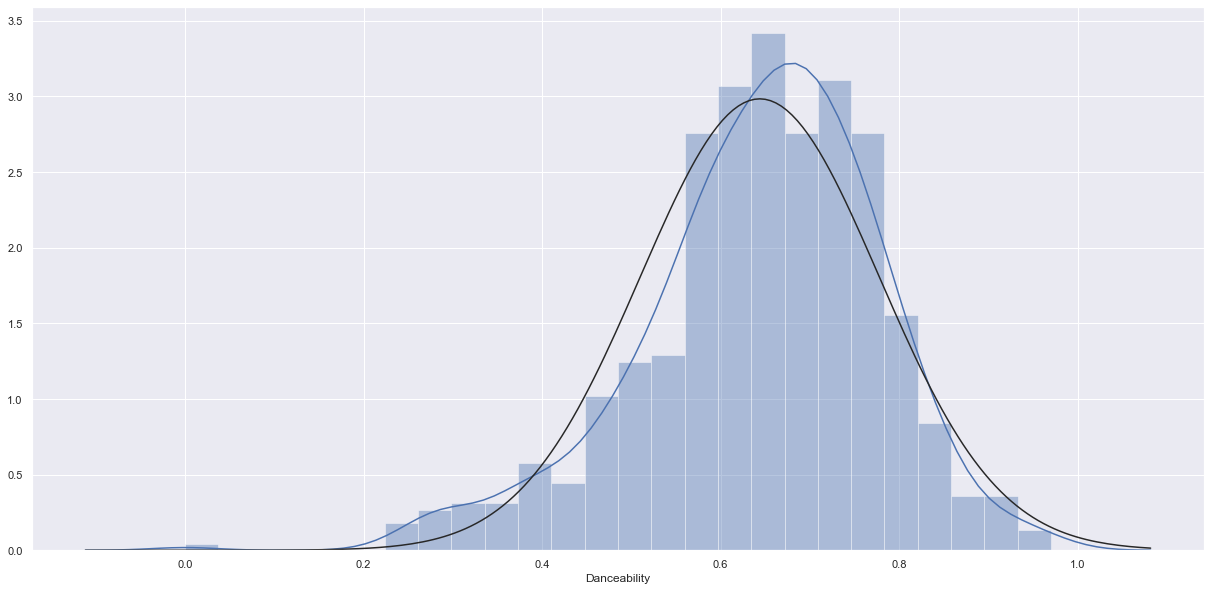

In [273]:
plot_dist(data["Danceability"])

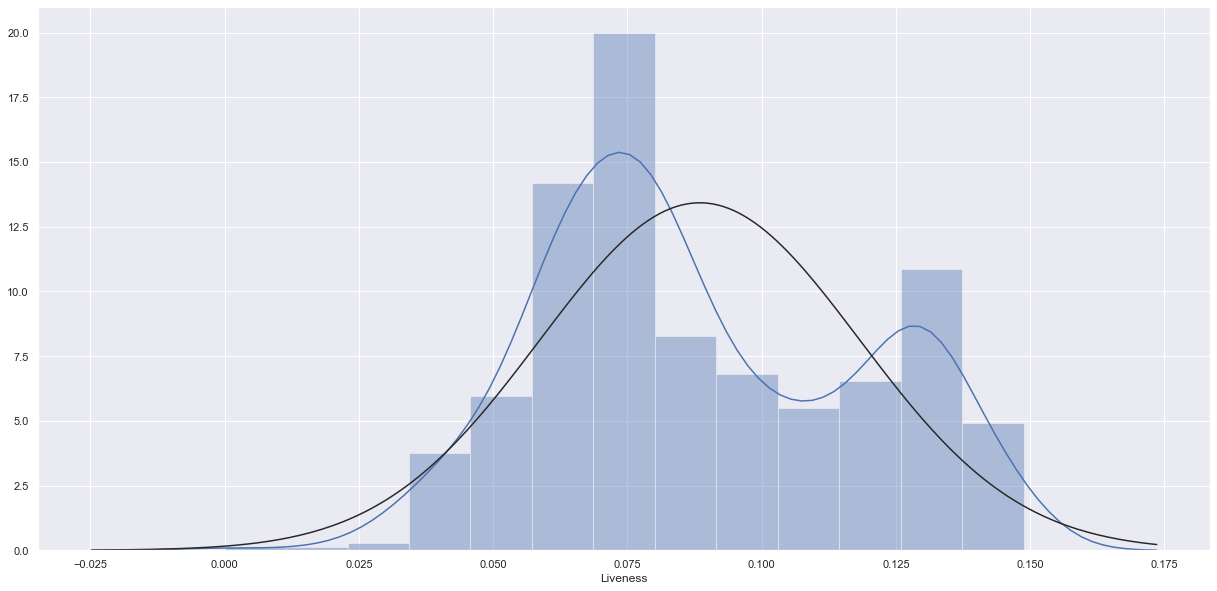

In [274]:
plot_dist(data["Liveness"])

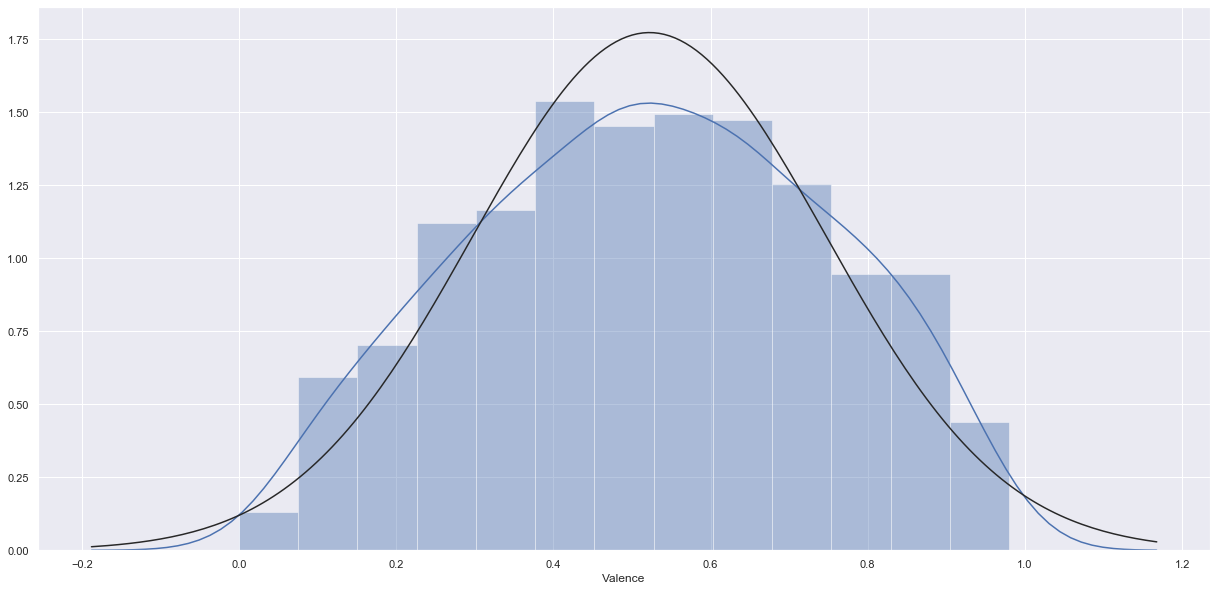

In [275]:
plot_dist(data["Valence"])

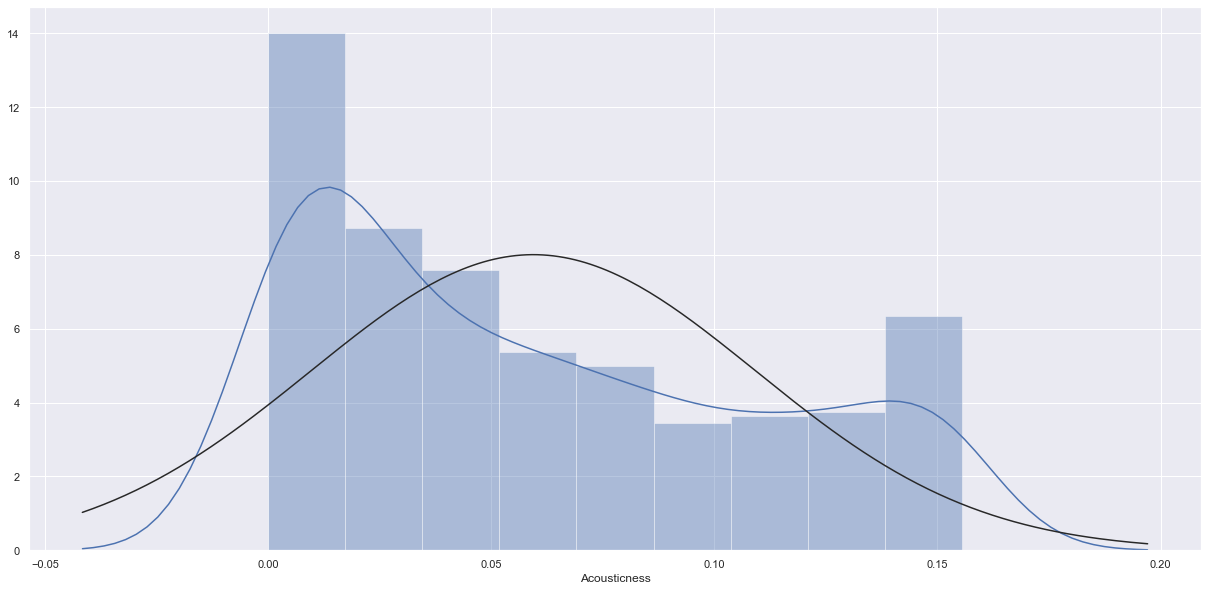

In [276]:
plot_dist(data["Acousticness"])

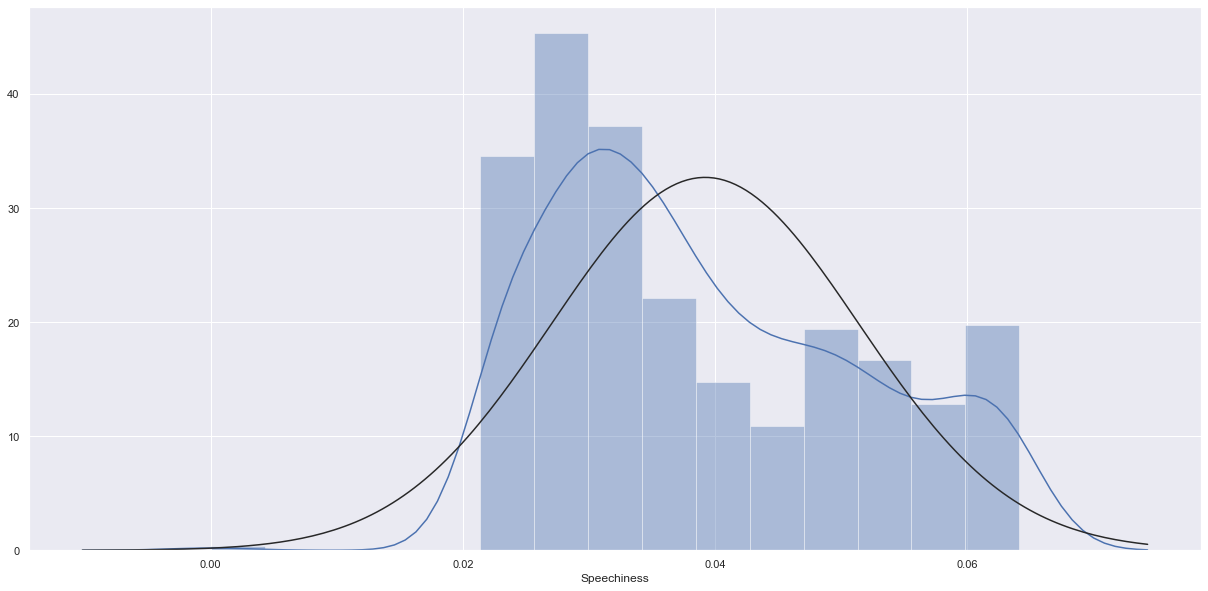

In [277]:
plot_dist(data["Speechiness"])

#### We will create 2 wordclouds, for top artists, one with 2010 - 2014 and another with 2015 - 2019. 

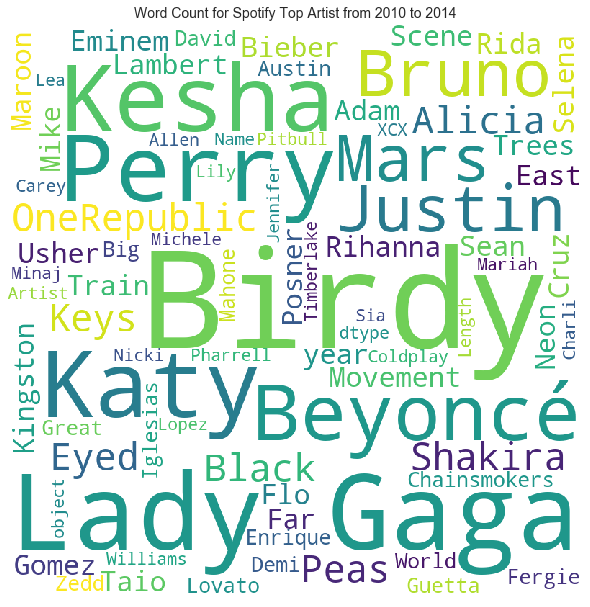

In [278]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ="white",  
                min_font_size = 10).generate(str(data_till14["Artist"])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Count for Spotify Top Artist from 2010 to 2014", fontsize = 14)
plt.show() 

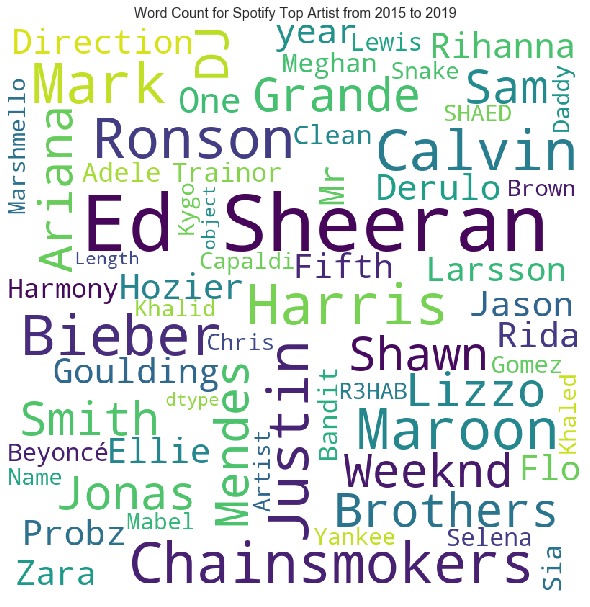

In [279]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ="white",  
                min_font_size = 10).generate(str(data_till19["Artist"])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Count for Spotify Top Artist from 2015 to 2019", fontsize = 14)
plt.show() 

#### We will split our data now, for algorithms (Logistic Regression and Random Forest Classifier), our target variable is Pop_or_not. Since our dataset is imbalanced we will use ROC curve for checking our model accuracy.

In [280]:
y = data["Pop_or_not"]

In [281]:
X = data[["Duration", "Beats_Per_Minute", "Energy","Danceability","Liveness","Valence", "Speechiness"]]

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [283]:
y_train.value_counts(normalize=True)

1    0.755187
0    0.244813
Name: Pop_or_not, dtype: float64

In [284]:
lr = LogisticRegression(random_state=0)

In [285]:
lr.fit(X_train, y_train)

/home/daminijain/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [286]:
lr_y_pred = lr.predict(X_test)

In [287]:
print("Accuracy of Logistic Regression model is: ", accuracy_score(y_test, lr_y_pred))

Accuracy of Logistic Regression model is:  0.7520661157024794


In [288]:
def plot_roc(model_preds, model_original):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(model_original, model_preds)
    
    plt.subplots(1, figsize=(10,10))
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC curve of Model", fontsize = 14)
    plt.show()
    

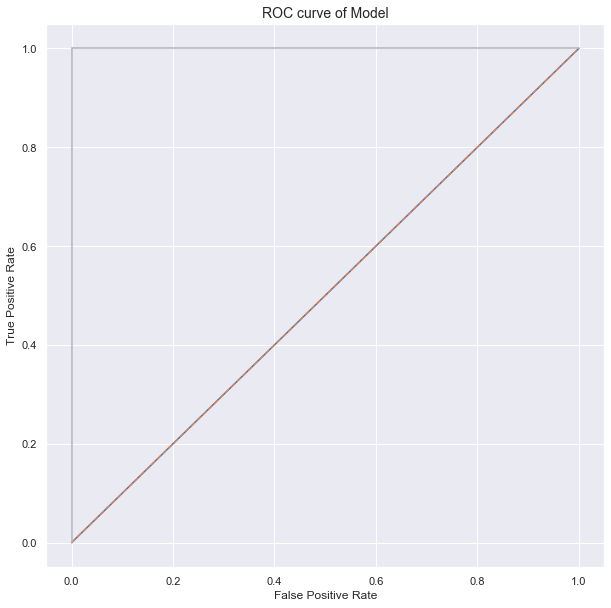

In [289]:
plot_roc(lr_y_pred, y_test)

In [290]:
rf = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=0)

In [291]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [292]:
forest_y_pred = rf.predict(X_test)

In [293]:
print("Accuracy of Random Forest Classfier is:",accuracy_score(y_test, forest_y_pred))

Accuracy of Random Forest Classfier is: 0.6776859504132231


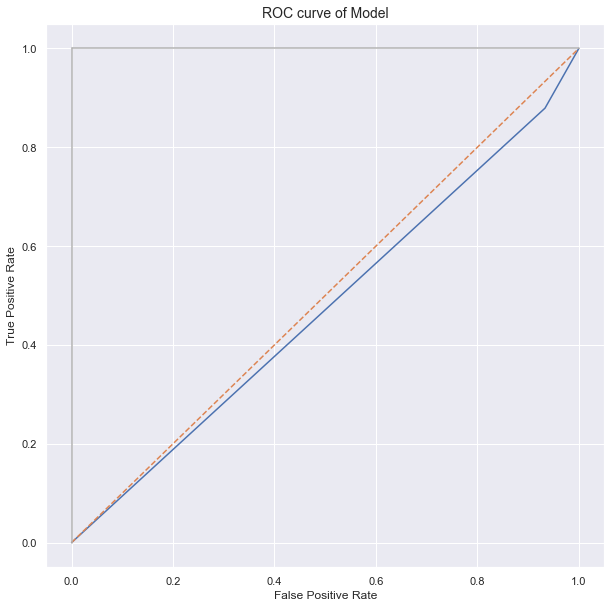

In [294]:
plot_roc(forest_y_pred, y_test)

#### Well, Random Forest has lower accuracy than Logistic Regression but by looking at the ROC curve its clear that Random Forest Classifier has performed better here due to the plot, it isnt the best but surely can be improved further :)

#### Random Forest offers us an amazing attribute which helps us to see the important features of our model. Gini Importance tells us the siginificane of a feature in our model.

In [295]:
feature_imp = pd.Series(rf.feature_importances_ ,index = X.columns).sort_values(ascending=False)

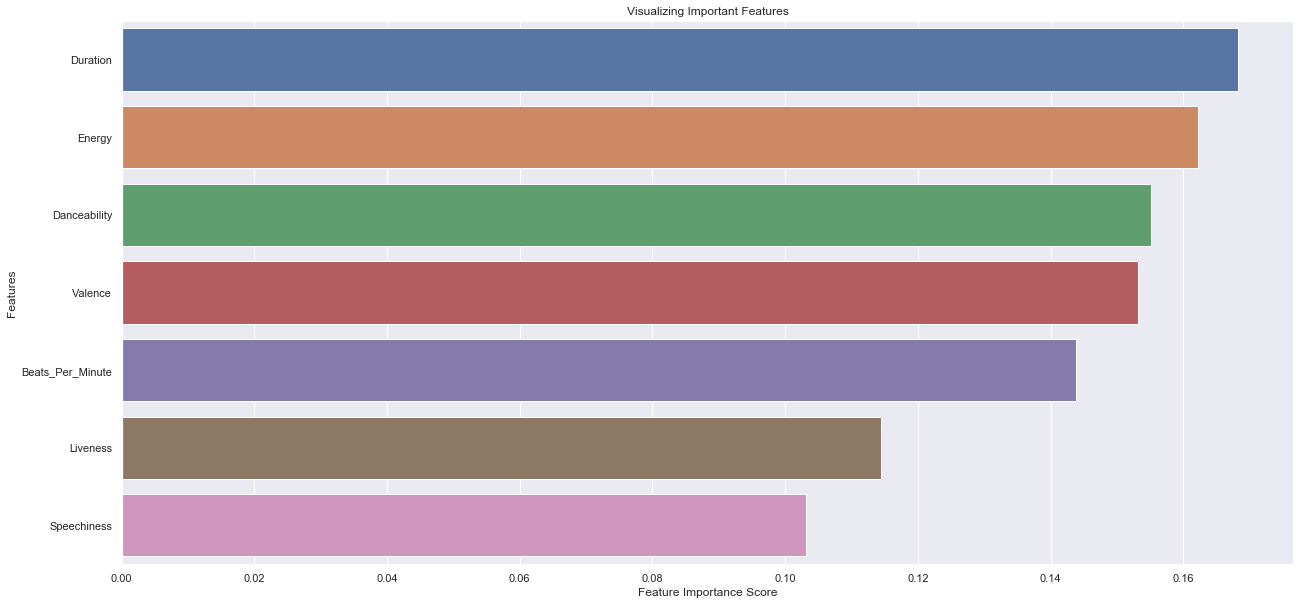

In [296]:
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.show()
